In [1]:
import scipy.special as sp
import math as ma
import numpy as np
import scipy.stats as st
import numba as nb
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
import bayessplicedmodels as bsm
from joblib import Parallel, delayed

# Lognormal distribution

$X\sim\text{Lognormal}(\mu, \sigma)$ with pdfs

$$
f(x) = \frac{1}{x\sigma\sqrt{2\pi}}\exp\left[-\frac{(\log(x)-\mu)^2}{2\sigma^2}\right]
$$

In [14]:
def phi_vec(z):
    """
    Cdf of unit normal distribution

    Parameters
    ----------
    z : Float

    Returns
    -------
    CDF of unit normal distribution
    """
    return( 1 / 2 * (1 + sp.erf(z /np.sqrt(2))))

@nb.jit(nopython=True)
def phi_jit(z):
    """
    Cdf of unit normal distribution

    Parameters
    ----------
    z : Float

    Returns
    -------
    CDF of unit normal distribution
    """
    return( 1 / 2 * (1 + ma.erf(z /np.sqrt(2))))

class loss_model:
    def __init__(self,name, parm_names):
        self.name = name
        self.parm_names = parm_names
        self.d= len(parm_names)
    
    def set_logp(self, X):
        if self.name == "Lognormal":
            def logp(parms):
                μ, σ = parms
                if σ > 0:
                    return(-len(X) * (np.log(σ) + np.log(2 * ma.pi) / 2) - np.sum(np.log(X)) - np.sum((np.log(X) - μ)**2) / 2 / σ **2)
                else:
                    return(-np.inf)
        self.logp = nb.jit(nopython = True)(logp)
    
    def set_logps(self):
        if self.name == "Lognormal":
            def logp_body(X, parms,  γ):
                μ, σ = parms
                F1 = phi_jit( (np.log(γ) - μ) / σ)
                if σ > 0 and F1 > 0:
                    return(-len(X) * (np.log(σ) + np.log(2 * ma.pi) / 2) - np.sum(np.log(X)) - np.sum((np.log(X) - μ)**2) / 2 / σ **2 - len(X) * np.log(F1))
                else:
                    return(-np.inf)
            
            def logp_tail(X, parms,  γ):
                μ, σ = parms
                F2 = phi_jit( (np.log(γ) - μ)  / σ)
                if σ > 0 and F2 < 1:
                    return(-len(X) * (np.log(σ) + np.log(2 * ma.pi) / 2) - np.sum(np.log(X)) - np.sum((np.log(X) - μ)**2) / 2 / σ **2 - len(X) * np.log(1 - F2))
                else:
                    return(-np.inf)
            
            self.logp_body = nb.jit(nopython = True)(logp_body)
            self.logp_tail = nb.jit(nopython = True)(logp_tail)
    
    def set_logd(self, parms):
        if self.name == "Lognormal":
            def logd(x):
                μ, σ = parms[:,0], parms[:,1]
                res = np.zeros(len(μ))
                s = σ > 0
                res[np.where(s)] =  - np.log(σ[s]) - np.log(2 * ma.pi) / 2 - np.log(x) - ((np.log(x) - μ[s])**2) / 2 / σ[s] **2
                res[np.where(np.invert(s))] = -np.inf
                return(res)
        self.logd = logd
    
    def set_logds(self):
        if self.name == "Lognormal":
            
            def logd_body(x, parms,  γ):
                μ, σ = parms[:,0], parms[:,1]
                res = np.zeros(len(μ))
                F1 = phi_vec((np.log(γ) - μ)  / σ)
                s = np.logical_and(np.logical_and(σ > 0 , x < γ), F1 > 0)
                res[np.where(s)] = - np.log(σ[s]) - np.log(2 * ma.pi) / 2 - np.log(x) - ((np.log(x) - μ[s])**2) / 2 / σ[s] **2 - np.log(F1[s])
                res[np.where(np.invert(s))] = -np.inf
                return(res)
            
            def logd_tail(x, parms,  γ):
                μ, σ = parms[:,0], parms[:,1]
                res = np.zeros(len(μ))
                F2 = phi_vec((np.log(γ) - μ)  / σ)
                s = np.logical_and(np.logical_and(σ > 0 , x > γ), F2 < 1 ) 
                res[np.where(s)] = - np.log(σ[s]) - np.log(2 * ma.pi) / 2 - np.log(x) - ((np.log(x) - μ[s])**2) / 2 / σ[s] **2 - np.log(1- F2[s])
                res[np.where(np.invert(s))] = -np.inf
                return(res)
            
            self.logd_body = logd_body
            self.logd_tail = logd_tail
                
    
        
    def set_cdf(self):
        if self.name == "Lognormal":
            def cdf(parms, x):
                μ, σ  = parms
                return(phi_jit( (np.log(x) - μ) / σ))
        self.cdf = nb.jit(nopython = True)(cdf)
    
    def set_pdf(self):
        if self.name == "Lognormal":
            def pdf(parms, x):
                μ, σ  = parms
                return(np.exp(- (np.log(x) - μ)**2 / 2 / σ**2 ) / x / σ / np.sqrt(2 * ma.pi))
        self.pdf = nb.jit(nopython = True)(pdf)
        
    def set_ppf(self):
        if self.name == "Lognormal":
            def ppf(parms, y):
                μ, σ  = parms
                return( np.exp(st.norm().ppf(y) * σ + μ))
        self.ppf = ppf
    
    def sample(self, parms, n):
        if self.name == "Lognormal":
            μ, σ = parms
            return(np.exp(st.norm().rvs(n) * σ + μ))

## Basic checks

In [16]:
lnorm_dist = loss_model("Lognormal", ["μ", "σ"])
print(lnorm_dist.name, lnorm_dist.parm_names, lnorm_dist.d)
μ, σ = np.array([10, 1/4])
x, y = 2, 0.5
parms = np.array([μ, σ])
lnorm_dist.set_cdf(), lnorm_dist.set_pdf(), lnorm_dist.set_ppf()
lnorm_dist.cdf(parms, x) - st.norm.cdf( (np.log(x) - μ) / σ), lnorm_dist.ppf(parms, y) - np.exp(st.norm().ppf(y) * σ + μ), lnorm_dist.pdf(parms, x) - st.norm.pdf( (np.log(x) - μ) / σ) / σ / x

Lognormal ['μ', 'σ'] 2


(-1.2293724106294937e-303, 0.0, 0.0)

## Log likelihood checks
### Part 1

In [17]:
X, γ = np.exp(st.norm().rvs(10) * σ + μ), 20000
lnorm_dist.set_logps(), lnorm_dist.set_logp(X)
print(lnorm_dist.logp(parms) - np.sum(np.log(st.norm.pdf((np.log(X) - μ) / σ) / X / σ)))

print(lnorm_dist.logp_body(X, parms, γ) -  np.sum(np.log(st.norm.pdf((np.log(X) - μ) / σ) / X / σ / st.norm.cdf( (np.log(γ) - μ) / σ) )))
print(lnorm_dist.logp_tail(X, parms, γ)-  np.sum(np.log(st.norm.pdf((np.log(X) - μ) / σ) / X / σ / (1 - st.norm.cdf( (np.log(γ) - μ) / σ)) )))

0.0
0.0
-1.4210854715202004e-14


### Part 2

In [18]:
X = np.exp(st.norm().rvs(10) * σ + μ)
import bayessplicedmodels as bsm
μ_prior, σ_prior, γ_prior= bsm.prior_model('normal','μ', 0, 1), bsm.prior_model('gamma','σ', 1, 1), bsm.prior_model('uniform','γ', min(X), max(X))
prior_single_model = bsm.independent_priors([μ_prior, σ_prior, γ_prior])
particle_cloud = prior_single_model.sample(20)
particle_cloud
lnorm_dist.set_logds(), lnorm_dist.set_logd(particle_cloud.values)
μ_vec, σ_vec, γ_vec = particle_cloud.values[:,0], particle_cloud.values[:,1],particle_cloud.values[:,2]
print(np.array([np.log(st.norm.pdf((np.log(X[0]) - μ_vec[i]) / σ_vec[i]) / X[0] / σ_vec[i]) for i in range(len(σ_vec))] - 
               lnorm_dist.logd(X[0])))
lnorm_dist.logd_body(X[0], particle_cloud.values, particle_cloud.values[:,-1]),lnorm_dist.logd_tail(X[0], particle_cloud.values, particle_cloud.values[:,-1])
print(lnorm_dist.logd_body(X[0], particle_cloud.values, particle_cloud.values[:,-1]) -np.array([np.log(st.norm.pdf((np.log(X[0]) - μ_vec[i]) / σ_vec[i]) / X[0] / σ_vec[i] / st.norm.cdf( (np.log(γ_vec[i]) - μ_vec[i]) / σ_vec[i])) for i in range(len(μ_vec)) ]) )
print(lnorm_dist.logd_tail(X[0], particle_cloud.values, particle_cloud.values[:,-1]) - 
      np.array([np.log(st.norm.pdf((np.log(X[0]) - μ_vec[i]) / σ_vec[i]) / X[0] / σ_vec[i] / (1 - st.norm.cdf( (np.log(γ_vec[i]) - μ_vec[i]) / σ_vec[i]))) for i in range(len(μ_vec)) ]) )

[-7.10542736e-15  0.00000000e+00            -inf -3.55271368e-15
            -inf            -inf -3.55271368e-15            -inf
 -1.42108547e-14  0.00000000e+00            -inf  3.55271368e-15
  3.55271368e-15  0.00000000e+00  0.00000000e+00            -inf
  0.00000000e+00  0.00000000e+00            -inf  0.00000000e+00]
[ 7.10542736e-15  0.00000000e+00             inf  3.55271368e-15
             inf             inf  3.55271368e-15             inf
  1.42108547e-14 -3.55271368e-15             inf -3.55271368e-15
  0.00000000e+00  0.00000000e+00  0.00000000e+00             inf
  3.55271368e-15  0.00000000e+00             inf -3.55271368e-15]
[-inf -inf  nan -inf  nan  nan -inf  nan -inf -inf  nan -inf -inf -inf
 -inf  nan -inf -inf  nan -inf]


C:\Users\pierr\AppData\Local\Temp/ipykernel_1660/3687213322.py:9: RuntimeWarning: divide by zero encountered in log
  print(np.array([np.log(st.norm.pdf((np.log(X[0]) - μ_vec[i]) / σ_vec[i]) / X[0] / σ_vec[i]) for i in range(len(σ_vec))] -
C:\Users\pierr\AppData\Local\Temp/ipykernel_1660/3687213322.py:12: RuntimeWarning: divide by zero encountered in log
  print(lnorm_dist.logd_body(X[0], particle_cloud.values, particle_cloud.values[:,-1]) -np.array([np.log(st.norm.pdf((np.log(X[0]) - μ_vec[i]) / σ_vec[i]) / X[0] / σ_vec[i] / st.norm.cdf( (np.log(γ_vec[i]) - μ_vec[i]) / σ_vec[i])) for i in range(len(μ_vec)) ]) )
C:\Users\pierr\AppData\Local\Temp/ipykernel_1660/3687213322.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  np.array([np.log(st.norm.pdf((np.log(X[0]) - μ_vec[i]) / σ_vec[i]) / X[0] / σ_vec[i] / (1 - st.norm.cdf( (np.log(γ_vec[i]) - μ_vec[i]) / σ_vec[i]))) for i in range(len(μ_vec)) ]) )
C:\Users\pierr\AppData\Local\Temp/ipykernel_1660/3687213322.py:14: Ru

## As a single model

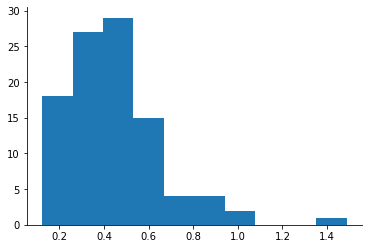

In [19]:
import bayessplicedmodels as bsm
parms_true = np.array([-1, 1/2])
f = loss_model("Lognormal", ["μ", "σ"])
X= f.sample(parms_true, 100)
plt.hist(X,bins=10)
sns.despine()
μ_prior, σ_prior = bsm.prior_model('normal','μ', 0, 10), bsm.prior_model('gamma','σ', 1, 1)
prior_single_model = bsm.independent_priors([μ_prior, σ_prior])

In [20]:
popSize, ρ, c, n_step_max, err, paralell, n_proc, verbose = 2000, 1/2, 0.99, 25, 1e-6, False, 4, True
%time trace, log_marg, DIC, WAIC = bsm.smc_likelihood_annealing(X, f, popSize, prior_single_model, ρ, c,n_step_max, err, paralell, 4, verbose)

Sample generation 0 from the normal-gamma prior distribution
Generation: 1 ;temperature: 0.00032138824462890625 ;ESS: 1000 ;steps:5 ;particle moved: 99.05000000000001%
Generation: 2 ;temperature: 0.004054423220168246 ;ESS: 1000 ;steps:5 ;particle moved: 98.2%
Generation: 3 ;temperature: 0.016454656927531577 ;ESS: 1000 ;steps:5 ;particle moved: 97.7%
Generation: 4 ;temperature: 0.04356682011797858 ;ESS: 1000 ;steps:5 ;particle moved: 99.15%
Generation: 5 ;temperature: 0.1162313369551895 ;ESS: 1000 ;steps:4 ;particle moved: 99.3%
Generation: 6 ;temperature: 0.34923312812269125 ;ESS: 1000 ;steps:4 ;particle moved: 99.9%
Generation: 7 ;temperature: 1.0 ;ESS: 1057 ;steps:4 ;particle moved: 99.75%
Wall time: 3.03 s


18.897933813361078 -59.05512286199482 -50.66308223649339


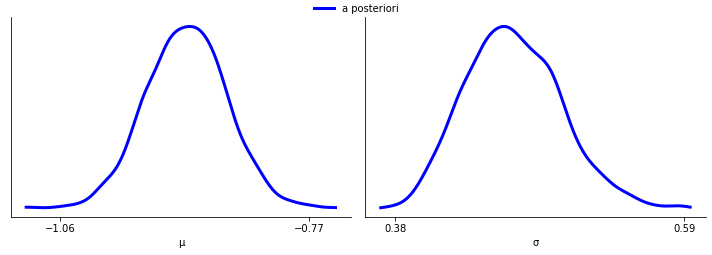

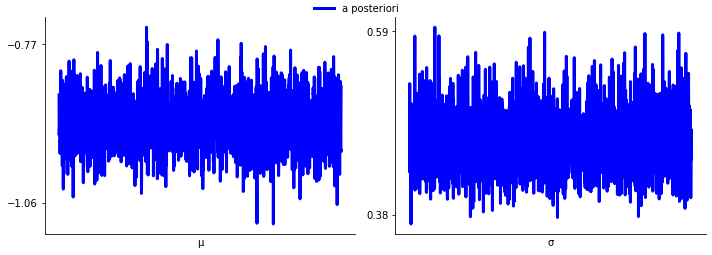

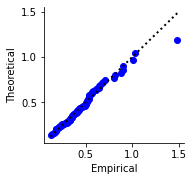

In [21]:
print(log_marg, DIC, WAIC)
bsm.posterior_plots(f, trace)
bsm.trace_plots(f, trace)
f.set_ppf()
bsm.qq_plot(X, f, trace.mean().values)

## In the composite model

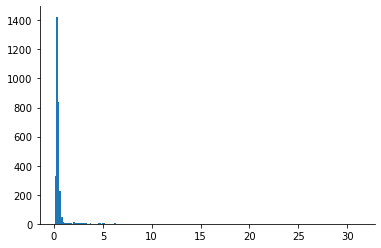

In [22]:
import bayessplicedmodels as bsm
parms_true = np.array([-1, 1/3, 1, 1, 1, 0.8])
f1, f2 =  loss_model("Lognormal", ["μ1", "σ1"]), loss_model("Lognormal", ["μ2", "σ2"])
f = bsm.spliced_loss_model(f1 , f2, "continuous") 
X= f.sample(parms_true, 3000) 
plt.hist(X,bins=200)
sns.despine()

In [27]:
μ1_prior, σ1_prior = bsm.prior_model('normal','μ1', 0, 1), bsm.prior_model('gamma','σ1', 1, 1)
μ2_prior, σ2_prior = bsm.prior_model('normal','μ2', 0, 1), bsm.prior_model('gamma','σ2', 1, 1)
γ_prior, p_prior =  bsm.prior_model('uniform','γ',min(X),max(X)), bsm.prior_model('beta', 'p', 0.5, 0.5)
prior_spliced_model = bsm.independent_priors([μ1_prior, σ1_prior, μ2_prior, σ2_prior, γ_prior])
popSize, ρ, c, n_step_max, err, paralell, n_proc, verbose = 2000, 1/2, 0.99, 25, 1e-6, False, 4, True
%time trace, log_marg, DIC, WAIC = bsm.smc_likelihood_annealing(X, f, popSize, prior_spliced_model, ρ, c,n_step_max, err, paralell, 4, verbose)

Sample generation 0 from the normal-gamma-normal-gamma-uniform prior distribution
Generation: 1 ;temperature: 3.719329833984375e-05 ;ESS: 998 ;steps:3 ;particle moved: 100.0%
Generation: 2 ;temperature: 0.0006523017932522635 ;ESS: 999 ;steps:3 ;particle moved: 100.0%
Generation: 3 ;temperature: 0.0017953843595850283 ;ESS: 1000 ;steps:3 ;particle moved: 99.95%
Generation: 4 ;temperature: 0.0035552395942498724 ;ESS: 1000 ;steps:3 ;particle moved: 99.95%
Generation: 5 ;temperature: 0.0054544377911423594 ;ESS: 1000 ;steps:3 ;particle moved: 99.75%
Generation: 6 ;temperature: 0.008553986124901033 ;ESS: 1000 ;steps:3 ;particle moved: 99.8%
Generation: 7 ;temperature: 0.017080403742023926 ;ESS: 1000 ;steps:3 ;particle moved: 99.95%
Generation: 8 ;temperature: 0.03508045350187114 ;ESS: 1000 ;steps:3 ;particle moved: 100.0%
Generation: 9 ;temperature: 0.07087650036636212 ;ESS: 1000 ;steps:3 ;particle moved: 99.95%
Generation: 10 ;temperature: 0.14023620390519764 ;ESS: 999 ;steps:3 ;particle mov

1180.7250874501647 -2417.4013699051907 -2396.4742589214425


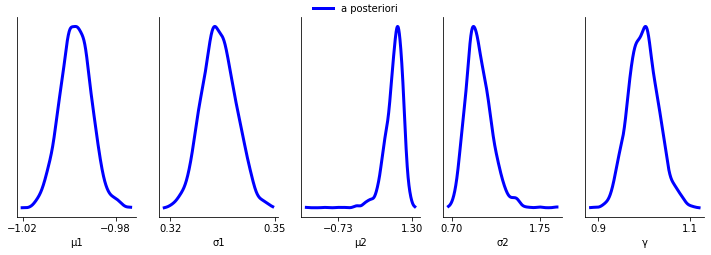

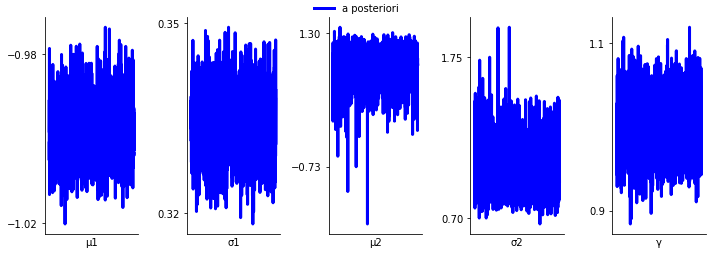

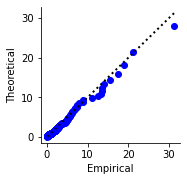

In [28]:
print(log_marg, DIC, WAIC)
bsm.posterior_plots(f, trace)
bsm.trace_plots(f, trace)
bsm.qq_plot(X, f, trace.mean().values)

# On the danish data set

In [38]:
# The data
danish = pd.read_csv("Data/danish.csv").x
X = danish.values
# Model for the bulk distribution
body_model_names = ["Lognormal"]
body_model_param_names = [["μ1", "σ1"]]
# Prior distributions over the parameters of the bulk distribution
body_model_priors= [
                [bsm.prior_model('normal',body_model_param_names[0][0], 0, 0.5), 
                 bsm.prior_model('gamma',body_model_param_names[0][1], 1, 1)]
]

# Model for the tail of the distribution
tail_model_names = ["Log-Logistic", "Lomax", "Burr", "Pareto-Tail", "GPD-Tail"]
tail_model_param_names = [["β2", "σ2"], ["α2", "σ2"], ["α2", "β2", "σ2"], ["α2"], ["ξ2","σ2"]]

# Prior distributions over the parameters of the bulk distribution
tail_model_priors= [[bsm.prior_model('gamma',tail_model_param_names[0][0], 1, 1), 
                 bsm.prior_model('gamma',tail_model_param_names[0][1], 1, 1)],
                [bsm.prior_model('gamma',tail_model_param_names[1][0], 1, 1), 
                 bsm.prior_model('gamma',tail_model_param_names[1][1], 1, 1)],
                [bsm.prior_model('gamma',tail_model_param_names[2][0], 1, 0.1), 
                 bsm.prior_model('gamma',tail_model_param_names[2][1], 1, 1), 
                 bsm.prior_model('gamma',tail_model_param_names[2][2], 1, 1)],
                [bsm.prior_model('gamma',tail_model_param_names[3][0], 1, 1)],
                [bsm.prior_model('gamma',tail_model_param_names[4][0], 1, 1), 
                 bsm.prior_model('gamma',tail_model_param_names[4][1], 1, 1)]
]
γ_prior, p_prior = bsm.prior_model('uniform', "γ", min(X), max(X)), bsm.prior_model('uniform',"p", 0, 1)

#Splicing model type
splicing_types = ["continuous"]

# Setting the models
fs, f_names, prior_spliced_model = [], [], []
for i in range(len(body_model_names)):
    for j in range(len(tail_model_names)):
        for splicing_type in splicing_types:
            f1, f2 =  bsm.loss_model(body_model_names[i], body_model_param_names[i]), bsm.loss_model(tail_model_names[j], tail_model_param_names[j])
            fs.append(bsm.spliced_loss_model(f1 , f2, splicing_type))
            f_names.append(body_model_names[i] +"-"+ tail_model_names[j]+"-"+splicing_type)
            if splicing_type == "disjoint": 
                prior_spliced_model.append(bsm.independent_priors(body_model_priors[i] + tail_model_priors[j] + [γ_prior, p_prior]))
            else:
                prior_spliced_model.append(bsm.independent_priors(body_model_priors[i] + tail_model_priors[j] + [γ_prior]))
fs_dict = dict(zip(f_names, fs))

In [39]:
popSize, ρ, c, n_step_max, err, paralell, n_proc, verbose = 4000, 1/2, 0.99, 25, 1e-6, False, 4, False
def fit_spliced_models(i):     
        trace, log_marg, DIC, WAIC = bsm.smc_likelihood_annealing(X, fs[i], popSize, prior_spliced_model[i], ρ, c,n_step_max, err, paralell, 4, verbose)
        return([trace, log_marg, DIC, WAIC])
%time res = Parallel(n_jobs=4)(delayed(fit_spliced_models)(i) for i in range(len(f_names)))

Wall time: 2min 30s


In [40]:
fit_spliced_models_dic = dict(zip(f_names, res))
γ_map = np.array([fit_spliced_models_dic[f_names[k]][0]['γ'].mean() for k in range(len(fit_spliced_models_dic))])
spliced_model_df = pd.DataFrame({'model':f_names,
                                 "d": np.array([f.d for f in fs]),
                                 "γ_map": np.array([fit_spliced_models_dic[f_names[k]][0]['γ'].mean() for k in range(len(fit_spliced_models_dic))]),
                                 'log_marg':  np.array([fit_spliced_models_dic[f_names[k]][1] for k in range(len(fit_spliced_models_dic))]), 
                                 "DIC": np.array([fit_spliced_models_dic[f_names[k]][2] for k in range(len(fit_spliced_models_dic))]), 
                                 "WAIC":np.array([fit_spliced_models_dic[f_names[k]][3] for k in range(len(fit_spliced_models_dic))])})
spliced_model_df["posterior_probability"] = np.exp(spliced_model_df["log_marg"] - np.max(spliced_model_df["log_marg"])) / np.sum(np.exp(spliced_model_df["log_marg"] - np.max(spliced_model_df["log_marg"]))) 

spliced_model_df["Wass_dist"] = np.array([bsm.compute_Wasserstein(X, fs_dict[model_name], fit_spliced_models_dic[model_name][0].mean().values, 1) for model_name in spliced_model_df["model"].values])
spliced_model_df.sort_values(by='log_marg', ascending=False)

,model,d,γ_map,log_marg,DIC,WAIC,posterior_probability,Wass_dist
1,Lognormal-Lomax-continuous,5,0.933305,-3852.697508,7645.263782,7669.147544,7.980654e-01,548.639400
0,Lognormal-Log-Logistic-continuous,5,0.930791,-3854.647693,7638.110760,7663.928757,1.135230e-01,477.570522
2,Lognormal-Burr-continuous,6,0.927312,-3854.974680,7649.318589,7661.286928,8.186069e-02,767.720251
4,Lognormal-GPD-Tail-continuous,5,0.933438,-3857.500100,7645.249345,7669.331423,6.550874e-03,543.076551
3,Lognormal-Pareto-Tail-continuous,4,0.963560,-3869.072865,7689.567152,7711.870741,6.170369e-08,1435.093265


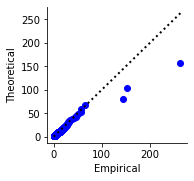

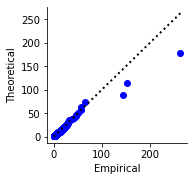

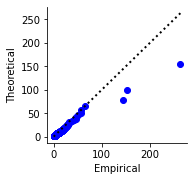

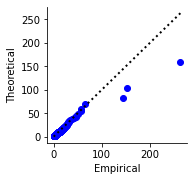

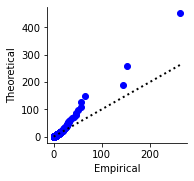

In [44]:
model_names = spliced_model_df.sort_values(by='log_marg', ascending=False)["model"]
for model_name in model_names:
    f, trace = fs_dict[model_name], fit_spliced_models_dic[model_name][0]
    # print(trace.mean().values)
    # bsm.posterior_plots(f, trace)
    # bsm.trace_plots(f, trace)
    
    bsm.qq_plot(X, f, trace.mean().values)